In [1]:
import matplotlib.pyplot as plt
import pandas as pd


from math import log

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion


# Create the data

In [2]:
OUTLOOK = [
    "sunny",
    "sunny",
    "overcast",
    "rainy",
    "rainy",
    "rainy",
    "overcast",
    "sunny",
    "sunny",
    "rainy",
    "sunny",
    "overcast",
    "overcast",
    "rainy",
]

TEMPERATURE = [
    "hot",
    "hot",
    "hot",
    "mild",
    "cool",
    "cool",
    "cool",
    "mild",
    "cool",
    "mild",
    "mild",
    "mild",
    "hot",
    "mild",
]
HUMIDITY = [
    "high",
    "high",
    "high",
    "high",
    "normal",
    "normal",
    "normal",
    "high",
    "normal",
    "normal",
    "normal",
    "high",
    "normal",
    "high",
]
WINDY = [
    False,
    True,
    False,
    False,
    False,
    True,
    True,
    False,
    False,
    False,
    True,
    True,
    False,
    True,
]
TARGET = [
    "no",
    "no",
    "yes",
    "yes",
    "yes",
    "no",
    "yes",
    "no",
    "yes",
    "yes",
    "yes",
    "yes",
    "yes",
    "no",
]

In [3]:
df = pd.DataFrame(
    {
        "outlook": OUTLOOK,
        "temperature": TEMPERATURE,
        "humidity": HUMIDITY,
        "windy": WINDY,
        "target": TARGET,
    }
)
df["windy"] = df["windy"].astype("str")

df

,outlook,temperature,humidity,windy,target
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [4]:
X = df.drop("target", axis=1)
y = df["target"]

In [5]:
def normalized_counts(df, feature):
    return df[feature].value_counts(normalize=True)


def calc_entropy_target(df, target: str):
    normed_counts = normalized_counts(df, target)
    return -sum(normed_counts * normed_counts.map(lambda x: log(x, 2)))


def calc_entropy_feature(df, feature: str, target: str):
    entropy = 0
    feature_labels = df[feature].unique()
    feature_labels_prob = normalized_counts(df, feature)

    for label in feature_labels:
        masked_df = df[df[feature] == label]
        label_entropy = calc_entropy_target(masked_df, target)

        label_prob = feature_labels_prob[label]

        entropy += label_prob * label_entropy
        
        print(f"{label} entropy: {label_entropy}")
    print(f"{feature} entropy: {entropy}")
    return entropy


def gain_information_feature(df, feature, target):
    target_entropy = calc_entropy_target(df, target)
    feature_entropy = calc_entropy_feature(df, feature, target)
    return target_entropy - feature_entropy


for feature_name in set(df.columns).difference(["target"]):
    print(f'{feature_name} gain information: {gain_information_feature(df, feature_name, "target")}')
    print("\n")

hot entropy: 1.0
mild entropy: 0.9182958340544896
cool entropy: 0.8112781244591328
temperature entropy: 0.9110633930116763
temperature gain information: 0.029222565658954647


high entropy: 0.9852281360342516
normal entropy: 0.5916727785823275
humidity entropy: 0.7884504573082896
humidity gain information: 0.15183550136234136


sunny entropy: 0.9709505944546686
overcast entropy: -0.0
rainy entropy: 0.9709505944546686
outlook entropy: 0.6935361388961918
outlook gain information: 0.2467498197744391


False entropy: 0.8112781244591328
True entropy: 1.0
windy entropy: 0.8921589282623617
windy gain information: 0.04812703040826927




The outlook feature has the highest gain information so that is going to be the first node we will split the decision tree. Thus we will have three branches:
- sunny_df
- overcast_df
- rainy_df

In [19]:
for feature_name in set(df[df["outlook"] == "sunny"].columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(df[df["outlook"] == "sunny"], feature_name, "target")}\n'
    )

hot entropy: -0.0
mild entropy: 1.0
cool entropy: -0.0
temperature entropy: 0.4
temperature gain information: 0.5709505944546686

high entropy: -0.0
normal entropy: -0.0
humidity entropy: 0.0
humidity gain information: 0.9709505944546686

sunny entropy: 0.9709505944546686
outlook entropy: 0.9709505944546686
outlook gain information: 0.0

False entropy: 0.9182958340544896
True entropy: 1.0
windy entropy: 0.9509775004326937
windy gain information: 0.01997309402197489



In [8]:
for feature_name in set(df[df["outlook"] == "rainy"].columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(df[df["outlook"] == "rainy"], feature_name, "target")}\n'
    )

mild entropy: 0.9182958340544896
cool entropy: 1.0
temperature entropy: 0.9509775004326937
temperature gain information: 0.01997309402197489

high entropy: 1.0
normal entropy: 0.9182958340544896
humidity entropy: 0.9509775004326937
humidity gain information: 0.01997309402197489

rainy entropy: 0.9709505944546686
outlook entropy: 0.9709505944546686
outlook gain information: 0.0

False entropy: -0.0
True entropy: -0.0
windy entropy: 0.0
windy gain information: 0.9709505944546686



In [20]:
for feature_name in set(df[df["outlook"] == "overcast"].columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(df[df["outlook"] == "overcast"], feature_name, "target")}\n'
    )

hot entropy: -0.0
cool entropy: -0.0
mild entropy: -0.0
temperature entropy: 0.0
temperature gain information: -0.0

high entropy: -0.0
normal entropy: -0.0
humidity entropy: 0.0
humidity gain information: -0.0

overcast entropy: -0.0
outlook entropy: 0.0
outlook gain information: -0.0

False entropy: -0.0
True entropy: -0.0
windy entropy: 0.0
windy gain information: -0.0



1st level: OUTLOOK

2nd level
- Sunny: HUMIDITY
- Rainy: WINDY
- Overcast: -

3rd level:




In [22]:
mask = (df["outlook"] == "sunny") & (df["humidity"] == "high")
masked_df = df[mask]

for feature_name in set(masked_df.columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(masked_df, feature_name, "target")}\n'
    )

masked_df

hot entropy: -0.0
mild entropy: -0.0
temperature entropy: 0.0
temperature gain information: -0.0

high entropy: -0.0
humidity entropy: 0.0
humidity gain information: -0.0

sunny entropy: -0.0
outlook entropy: 0.0
outlook gain information: -0.0

False entropy: -0.0
True entropy: -0.0
windy entropy: 0.0
windy gain information: -0.0



,outlook,temperature,humidity,windy,target
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
7,sunny,mild,high,False,no


In [11]:
mask = (df["outlook"] == "sunny") & (df["humidity"] == "normal")
masked_df = df[mask]

for feature_name in set(masked_df.columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(masked_df, feature_name, "target")}\n'
    )
masked_df

cool entropy: -0.0
mild entropy: -0.0
temperature entropy: 0.0
temperature gain information: -0.0

normal entropy: -0.0
humidity entropy: 0.0
humidity gain information: -0.0

sunny entropy: -0.0
outlook entropy: 0.0
outlook gain information: -0.0

False entropy: -0.0
True entropy: -0.0
windy entropy: 0.0
windy gain information: -0.0



,outlook,temperature,humidity,windy,target
8,sunny,cool,normal,False,yes
10,sunny,mild,normal,True,yes


In [12]:
mask = (df["outlook"] == "rainy") & (df["windy"] == "False")
masked_df = df[mask]

for feature_name in set(masked_df.columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(masked_df, feature_name, "target")}\n'
    )
masked_df

mild entropy: -0.0
cool entropy: -0.0
temperature entropy: 0.0
temperature gain information: -0.0

high entropy: -0.0
normal entropy: -0.0
humidity entropy: 0.0
humidity gain information: -0.0

rainy entropy: -0.0
outlook entropy: 0.0
outlook gain information: -0.0

False entropy: -0.0
windy entropy: 0.0
windy gain information: -0.0



,outlook,temperature,humidity,windy,target
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [13]:
mask = (df["outlook"] == "rainy") & (df["windy"] == "True")
masked_df = df[mask]

for feature_name in set(masked_df.columns).difference(
    ["target"]
):
    print(
        f'{feature_name} gain information: {gain_information_feature(masked_df, feature_name, "target")}\n'
    )
masked_df

cool entropy: -0.0
mild entropy: -0.0
temperature entropy: 0.0
temperature gain information: -0.0

normal entropy: -0.0
high entropy: -0.0
humidity entropy: 0.0
humidity gain information: -0.0

rainy entropy: -0.0
outlook entropy: 0.0
outlook gain information: -0.0

True entropy: -0.0
windy entropy: 0.0
windy gain information: -0.0



,outlook,temperature,humidity,windy,target
5,rainy,cool,normal,True,no
13,rainy,mild,high,True,no


# Classifier

In [14]:
class Selector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

    
class OrdinalEncoding(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.oe = OrdinalEncoder()
        self.oe.fit(X)
        return self
    
    def transform(self, X, y=None):
        return self.oe.transform(X)

In [15]:
CAT_COLUMNS = ["outlook", "temperature", "humidity", "windy"]

pipeline = Pipeline(
    [("selector", Selector(CAT_COLUMNS)), ("ordinal_encoder", OrdinalEncoding())]
)

X_prepared = pipeline.fit_transform(df)
X_prepared = pd.DataFrame(X_prepared, columns=CAT_COLUMNS).astype("int")
X_prepared

,outlook,temperature,humidity,windy
0,2,1,0,0
1,2,1,0,1
2,0,1,0,0
3,1,2,0,0
4,1,0,1,0
5,1,0,1,1
6,0,0,1,1
7,2,2,0,0
8,2,0,1,0
9,1,2,1,0


In [16]:
pipeline.named_steps["ordinal_encoder"].oe.inverse_transform(X_prepared)[:, 0]

array(['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy',
       'overcast', 'sunny', 'sunny', 'rainy', 'sunny', 'overcast',
       'overcast', 'rainy'], dtype=object)

# Feature importance

In [68]:
clf = DecisionTreeClassifier(random_state=42, criterion="entropy")

clf.fit(X_prepared, y)

pd.DataFrame(
    index=[X.columns], data=clf.tree_.compute_feature_importances(normalize=False), columns=["feature_importance"]
)

,feature_importance
outlook,0.340975
temperature,0.142857
humidity,0.198623
windy,0.257831


In [64]:
clf.tree_.compute_feature_importances(normalize=False)

array([0.34097456, 0.14285714, 0.19862279, 0.25783146])

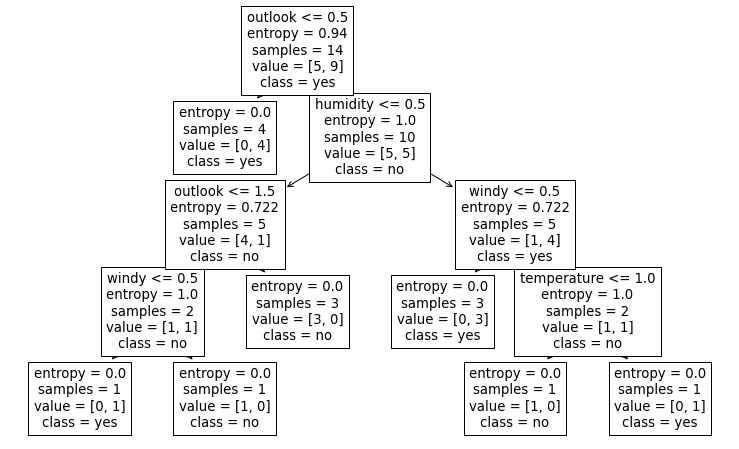

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
tree.plot_tree(clf, feature_names=X.columns, class_names=y.unique());

Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.